In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from esn_module import esn

from echo_state_tests import gen_in_out_one_in_subs, test_XOR

from scipy.sparse import csr_matrix

/home/fschubert/work/py36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [157]:
class RNN:
    
    def __init__(self,
                N=1000,
                cf=.1,
                cf_w_in=.1,
                sigm_w=1.,
                sigm_w_in=1.,
                sigm_w_out_init=.1,
                tau=1.,
                data_dim_in=1,
                data_dim_out=1,
                eps_a=0.0001):
        
        self.N = N
        
        self.W = np.random.normal(0.,sigm_w/(N*cf)**.5,(N,N))*(np.random.rand(N,N) <= cf)
        self.W[range(N),range(N)] = 0.
        
        self.cf = (1.*(self.W!=0.)).sum()/N**2.
        
        if self.cf < .5:
            self.W = csr_matrix(self.W)
            self.sparse_W = True
        else:
            self.sparse_W = False
            
        self.data_dim_in = data_dim_in
        self.data_dim_out = data_dim_out
        
        self.w_in = np.random.normal(0.,sigm_w_in,(self.N,self.data_dim_in))*(np.random.rand(self.N,self.data_dim_in) <= cf_w_in)
        
        self.cf_w_in = (1.*(self.w_in!=0.)).sum()/(N*data_dim_in)
        
        self.w_out = np.random.rand(data_dim_out,self.N+1)-.5
        self.w_out[:,0] = 0.
        
        self.tau = tau
        
        self.a = np.ones(self.N)
        
        self.eps_a = eps_a
    
    def check_data_in_comp(self,data):

        if len(data.shape)==1:
            if self.data_dim_in != 1:
                print("input dimensions do not fit!")
                sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.data_dim_in):
            print("input dimensions do not fit!")
            sys.exit()

        return data
    
    def check_data_out_comp(self,data):

        if len(data.shape)==1:
            if self.data_dim_out != 1:
                print("output dimensions do not fit!")
                #sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.data_dim_out):
            print("output dimensions do not fit!")
            #sys.exit()

        return data
    
    def learn_global_gain_RTRL(self,
                               u_in,
                               u_out,
                  T_batch_w_out=None,
                    tau_batch_w_out = 1.,
                    reg_fact = 0.01,
                  T_skip_rec=10):
        
        if T_batch_w_out == None:
            T_batch_w_out = self.N*4
        
        u_in = self.check_data_in_comp(u_in)
        u_out = self.check_data_out_comp(u_out)
        
        if u_in.shape[0] == u_out.shape[0]:
            T = u_in.shape[0]
        else:
            print("length of time series do not match!")
        
        ### recording
        
        T_rec = int(T/T_skip_rec)
        
        y_rec = np.ndarray((T_rec,self.N))
        a_rec = np.ndarray((T_rec))
        
        Err_rec = np.ndarray((T_rec))
        
        w_out_rec = np.ndarray((T_rec,self.data_dim_out,self.N+1))
        
        y_rec_w_out_learn = np.zeros((T_batch_w_out,self.N+1))

        u_out_w_out_learn = np.zeros((T_batch_w_out,self.data_dim_out))
        ###
        
        y = np.random.rand(self.N+1)-.5
        y[0] = 0.
        
        dyda = np.zeros((self.N))
        
        for t in tqdm(range(T)):
            
            X_r = self.W.dot(y[1:])
            
            X_e = self.w_in.dot(u_in[t,:])
            
            y[1:] = np.tanh(self.a*X_r + X_e)
            
            y_rec_w_out_learn[t%T_batch_w_out,:] = y[:]

            u_out_w_out_learn[t%T_batch_w_out,:] = u_out[t,:]
            
            O = self.w_out.dot(y)
            
            
            if t%T_batch_w_out == 0 and t>0.:
                
                self.w_out = self.w_out + (1./tau_batch_w_out)*( -self.w_out + (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(self.N+1)) @ y_rec_w_out_learn.T @ u_out_w_out_learn).T)
                   
            err = O - u_out[t,:]
            
            dyda = (1-y[1:]**2.)*(X_r + self.a[0]*self.W.dot(dyda))
            
            if t >= T_batch_w_out:
            
                

                delta_a = -self.eps_a*err.dot(self.w_out[:,1:].dot(dyda))

                self.a += delta_a

                self.a = np.maximum(0.01,self.a)
            
            ### recording
            
            if t%T_skip_rec == 0:
                
                t_rec = int(t/T_skip_rec)
                
                y_rec[t_rec,:] = y[1:]
                a_rec[t_rec] = self.a[0]

                Err_rec[t_rec] = .5*(err**2.).sum()
                
                w_out_rec[t_rec,:,:] = self.w_out
                
        t_ax = np.array(range(T_rec))*T_skip_rec
        
        return t_ax,y_rec, a_rec, w_out_rec, Err_rec

    def learn_global_gain_Local(self,
                               u_in,
                               u_out,
                  T_batch_w_out=None,
                    tau_batch_w_out = 1.,
                    reg_fact = 0.01,
                  T_skip_rec=10):
        
        if T_batch_w_out == None:
            T_batch_w_out = self.N*4
        
        u_in = self.check_data_in_comp(u_in)
        u_out = self.check_data_out_comp(u_out)
        
        if u_in.shape[0] == u_out.shape[0]:
            T = u_in.shape[0]
        else:
            print("length of time series do not match!")
        
        ### recording
        
        T_rec = int(T/T_skip_rec)
        
        y_rec = np.ndarray((T_rec,self.N))
        a_rec = np.ndarray((T_rec))
        
        Err_rec = np.ndarray((T_rec))
        
        w_out_rec = np.ndarray((T_rec,self.data_dim_out,self.N+1))
        
        y_rec_w_out_learn = np.zeros((T_batch_w_out,self.N+1))

        u_out_w_out_learn = np.zeros((T_batch_w_out,self.data_dim_out))
        ###
        
        y = np.random.rand(self.N+1)-.5
        y[0] = 0.
        
        dyda = np.zeros((self.N))
        
        for t in tqdm(range(T)):
            
            X_r = self.W.dot(y[1:])
            
            X_e = self.w_in.dot(u_in[t,:])
            
            y[1:] = np.tanh(self.a*X_r + X_e)
            
            y_rec_w_out_learn[t%T_batch_w_out,:] = y[:]

            u_out_w_out_learn[t%T_batch_w_out,:] = u_out[t,:]
            
            O = self.w_out.dot(y)
            
            
            if t%T_batch_w_out == 0 and t>0.:
                
                self.w_out = self.w_out + (1./tau_batch_w_out)*( -self.w_out + (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(self.N+1)) @ y_rec_w_out_learn.T @ u_out_w_out_learn).T)
                   
            err = O - u_out[t,:]
            
            dyda = (1-y[1:]**2.)*X_r
            
            if t >= T_batch_w_out:
            
                

                delta_a = -self.eps_a*err.dot(self.w_out[:,1:].dot(dyda))

                self.a += delta_a

                self.a = np.maximum(0.01,self.a)
            
            ### recording
            
            if t%T_skip_rec == 0:
                
                t_rec = int(t/T_skip_rec)
                
                y_rec[t_rec,:] = y[1:]
                a_rec[t_rec] = self.a[0]

                Err_rec[t_rec] = .5*(err**2.).sum()
                
                w_out_rec[t_rec,:,:] = self.w_out
                
        t_ax = np.array(range(T_rec))*T_skip_rec
        
        return t_ax,y_rec, a_rec, w_out_rec, Err_rec
    
    def learn_w_out(self,u_in,u_target,reg_fact=0.01,t_prerun=0):

        u_in = self.check_data_in_comp(u_in)
        u_target = self.check_data_out_comp(u_target)

        n_t = u_in.shape[0]

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.


        y[0,1:] = np.tanh(self.w_in @ u_in[0,:])


        for t in tqdm(range(1,n_t)):

            y[t,1:] = np.tanh(self.a*self.W.dot(y[t-1,1:]) + self.w_in @ u_in[t,:])
        
        self.w_out[:,:] = (np.linalg.inv(y[t_prerun:,:].T @ y[t_prerun:,:] + reg_fact*np.eye(self.N+1)) @ y[t_prerun:,:].T @ u_target[t_prerun:,:]).T
    
    def predict_data(self,data,return_reservoir_rec=False):

        data = self.check_data_in_comp(data)

        n_t = data.shape[0]

        u_in = data

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        y[0,1:] = np.tanh(self.w_in @ u_in[0,:])

        for t in tqdm(range(1,n_t)):

            y[t,1:] = np.tanh(self.a*self.W.dot(y[t-1,1:]) + self.w_in @ u_in[t,:])

        out = (self.w_out @ y.T).T
        if self.data_dim_out == 1:
            out = out[:,0]

        if return_reservoir_rec:
            return (out,y)
        else:
            return out
    

In [187]:
tau_max = 25

tau_delay = np.arange(tau_max)
gain = np.ndarray((tau_max))

MC = np.ndarray((tau_max))

for k,tau in tqdm(enumerate(tau_delay)):

    rnn = RNN(N=500)

    u_in,u_out = gen_in_out_one_in_subs(1500000,tau)

    t,y,a,w_out,E = rnn.learn_global_gain_RTRL(u_in,u_out,tau_batch_w_out=1.)
    
    gain[k] = a[-1]
    
    u_in_learn,u_out_learn = gen_in_out_one_in_subs(10000,tau)
    u_in_test,u_out_test = gen_in_out_one_in_subs(10000,tau)

    rnn.learn_w_out(u_in_learn,u_out_learn)

    u_out_pred = rnn.predict_data(u_in_test)
    
    MC[k] = np.corrcoef(u_out_test,u_out_pred)[0,1]**2.
    
    

In [ ]:
gain_local = np.ndarray((tau_max))
MC_local = np.ndarray((tau_max))


for k,tau in tqdm(enumerate(tau_delay)):

    rnn = RNN(N=500)

    u_in,u_out = gen_in_out_one_in_subs(1500000,tau)

    t,y,a,w_out,E = rnn.learn_global_gain_Local(u_in,u_out,tau_batch_w_out=1.)
    
    gain_local[k] = a[-1]
    
    u_in_learn,u_out_learn = gen_in_out_one_in_subs(10000,tau)
    u_in_test,u_out_test = gen_in_out_one_in_subs(10000,tau)

    rnn.learn_w_out(u_in_learn,u_out_learn)

    u_out_pred = rnn.predict_data(u_in_test)
    
    MC_local[k] = np.corrcoef(u_out_test,u_out_pred)[0,1]**2.

In [ ]:
plt.plot(tau_delay,gain,label='RTRL')
plt.plot(tau_delay,gain_local,label='Local Gradient')
plt.xlabel("Time delay")
plt.ylabel("Gain")
plt.legend()
plt.show()

In [ ]:
plt.plot(tau_delay,MC)
plt.plot(tau_delay,MC_local)
plt.ylim([0.,1.])
plt.show()

In [174]:
rnn = RNN(N=500)
rnn_RTRL = RNN(N=500)

u_in,u_out = gen_in_out_one_in_subs(1500000,5)

t,y,a,w_out,E = rnn.learn_global_gain_Local(u_in,u_out,tau_batch_w_out=1.)
t,y_RTRL,a_RTRL,w_out_RTRL,E_RTRL = rnn_RTRL.learn_global_gain_RTRL(u_in,u_out,tau_batch_w_out=1.)

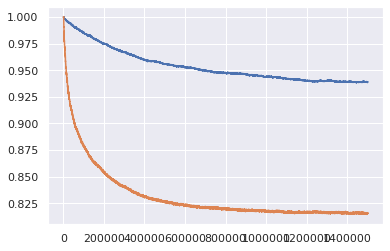

In [175]:
plt.plot(t,a)
plt.plot(t,a_RTRL)
plt.show()

In [176]:
u_in_learn,u_out_learn = gen_in_out_one_in_subs(10000,5)
u_in_test,u_out_test = gen_in_out_one_in_subs(10000,5)

rnn.learn_w_out(u_in_learn,u_out_learn)
rnn_RTRL.learn_w_out(u_in_learn,u_out_learn)

u_out_pred = rnn.predict_data(u_in_test)
u_out_pred_RTRL = rnn_RTRL.predict_data(u_in_test)

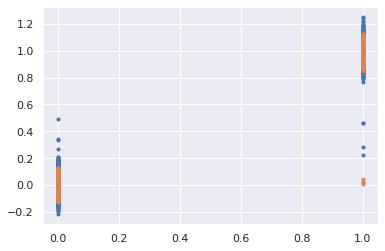

In [177]:
plt.plot(u_out_test,u_out_pred,'.')
plt.plot(u_out_test,u_out_pred_RTRL,'.')
plt.show()

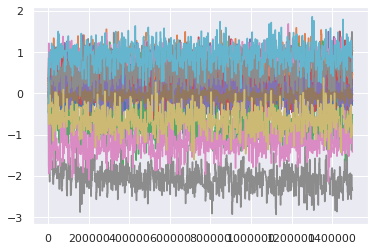

In [139]:
plt.plot(t,w_out[:,0,:20])
plt.show()